In [11]:
import nltk
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import random as rd
from matplotlib import pyplot as plt
from nltk.corpus import wordnet as wn
%matplotlib inline

## Reading and Preprocessing Data
Parsing xml train and dev data
Tokenising text/questions/answers, getting rid of punctuation and upper cases 

In [23]:
xml_train = open('MCScript/train-data.xml').read()
xml_dev = open('MCScript/dev-data.xml').read()
xml_test = open('MCScript/test-data.xml').read()

In [24]:
# method to preprocess data

punctuation_and_extra = set(list('!"#$%&\'()*+,-./:;<=>? @[\\]^_`{|}~£'))
punctuation_and_extra.update(["'s", "n't", "``", "''", "'ll", "'m", "'d", "'ve", "wa"])

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokenised_text = []
    for word in tokens:
        if ":" in word: #to deal with time formats, e.g. 5:00am
            new_word = word.replace(":", " ")
            tokenised_text.append(new_word.lower())
        else:
            if (wn.morphy(word.lower()) != None):
                tokenised_text.append(wn.morphy(word.lower()))
            else:
                tokenised_text.append(word.lower())
    tokenised_text = list(filter(lambda x: x not in punctuation_and_extra, tokenised_text))
    return tokenised_text

In [25]:
# method to read data from xml

def xml2listData(xml_data):
    data = []
    root = ET.XML(xml_data)
    for child in root:
        instance = {}
        for subchild in child:
            if subchild.tag == 'text':
                instance['text_id'] = child.attrib["id"]
                instance[subchild.tag] = preprocess_text(subchild.text)
            if subchild.tag == 'questions':
                questions = []
                for question in subchild:
                    single_question = {}
                    single_question['question_id'] = question.attrib["id"]
                    single_question['question_text'] = preprocess_text(question.attrib["text"])
                    answers = []
                    for answer in question:
                        single_answer = {}
                        single_answer['answer_id'] = answer.attrib["id"]
                        single_answer['answer_text'] = preprocess_text(answer.attrib["text"])
                        single_answer['correct'] = answer.attrib["correct"]
                        answers.append(single_answer)
                    single_question['answers'] = answers
                    questions.append(single_question)
                instance['questions'] = questions
        data.append(instance)
    return data

In [26]:
train_data = xml2listData(xml_train)
dev_data = xml2listData(xml_dev)
test_data = xml2listData(xml_test)

Parsing and preprocessing knowledge script data

In [30]:
# method to read DeScript xml

def xml2listDeScript(xml_file):
    data = []
    root = ET.XML(xml_file)
    for label in root:
        for item in label:
            data.append(preprocess_text(item.attrib["original"]))
    return data

In [15]:
import glob
# returns a list of strings which are names of files
first_gold_standard = glob.glob("./DeScript_LREC2016/gold_paraphrase_sets/first_gold_annotation/*.xml")
second_gold_standard = glob.glob("./DeScript_LREC2016/gold_paraphrase_sets/second_gold_annotation/*.xml")

In [16]:
def scriptFiles_to_lists(scriptFiles):
    topcs = []
    for filename in scriptFiles:
        current_file = open(filename).read()
        topcs.append(xml2listDeScript(current_file))
    return topcs

topcs1 = scriptFiles_to_lists(first_gold_standard)
topcs2 = scriptFiles_to_lists(second_gold_standard)

In [17]:
# creating a dictionary with topics from both gold standards
topics = {'baking_a_cake': np.concatenate(topcs1[0]+topcs2[0]),  'book_from_library': np.concatenate(topcs1[1]+topcs2[1]), 'airplane_flying': np.concatenate(topcs1[2]+topcs2[2]), 
          'hair_cut': np.concatenate(topcs1[3]+topcs2[3]), 'grocery_shopping': np.concatenate(topcs1[4]+topcs2[4]),'on_the_train': np.concatenate(topcs1[5]+topcs2[5]), 
          'planting_a_tree': np.concatenate(topcs1[6]+topcs2[6]), 'repair_flat_bike_tyre': np.concatenate(topcs1[7]+topcs2[7]), 
          'on_the_bus': np.concatenate(topcs1[8]+topcs2[8]), 'taking_bath': np.concatenate(topcs1[9]+topcs2[9])}

In [18]:
# a dictionary with docs within topics
topic_docs = {'baking_a_cake': topcs1[0]+topcs2[0],  'book_from_library': topcs1[1]+topcs2[1], 'airplane_flying': topcs1[2]+topcs2[2], 
          'hair_cut': topcs1[3]+topcs2[3], 'grocery_shopping': topcs1[4]+topcs2[4],'on_the_train': topcs1[5]+topcs2[5], 
          'planting_a_tree': topcs1[6]+topcs2[6], 'repair_flat_bike_tyre': topcs1[7]+topcs2[7], 
          'on_the_bus': topcs1[8]+topcs2[8], 'taking_bath': topcs1[9]+topcs2[9]}

## Evaluation Script

In [31]:
def get_gold(data):
    gold_standard = []
    for instance in data:
        for question in instance['questions']:
            instance_result = [instance['text_id']]
            instance_result.append(question['question_id'])
            for answer in question['answers']:
                if answer['correct'] == 'True':
                    instance_result.append(answer['answer_id'])
            gold_standard.append(instance_result)
    return gold_standard

In [36]:
gold_train = get_gold(train_data)
gold_dev = get_gold(dev_data)
gold_test = get_gold(test_data)

In [38]:
# evaluating accuracy, returning a tuple with percentage and list of incorrect answers
def evaluate(results, ideal_results):
    if (len(results) != len(ideal_results)):
        raise Exception("Different length of your result and ideal results")
    correct_answers = 0
    all_answers = len(results)
    incorrect_answers = []
    for i in range(all_answers):
        if results[i] == ideal_results[i]:
            correct_answers += 1
        else:
            incorrect_answers.append(results[i])
    return ((correct_answers/all_answers)*100, incorrect_answers)

## Saving Data to File

In [39]:
def save_results(results):
    f = open('answer.txt', 'w')
    for res in results:
        f.write(",".join(res) + "\n")
    f.close()

## Answering Questions
- part 1: answer using only the given text
- part 2: answer using other texts with similar topics
- part 3: answer using text + knowledge

### Part 1. Baseline. Answering Using The Given Text Only

In [48]:
stopwords = set(nltk.corpus.stopwords.words("english"))

In [49]:
# getting the longest answer length
from operator import itemgetter
all_answers = []
for instance in train_data+dev_data:
    for question in instance['questions']:
        for answer in question['answers']:
            all_answers.append((instance['text_id'], question['question_id'], len(answer['answer_text'])))
max(all_answers,key=itemgetter(2))

('917', '1', 28)

In [40]:
def choose_answer(text, answers):
    answer_scores = {}
    for answer in answers:
        if " ".join(answer['answer_text']) in " ".join(text):
            answer_scores[answer['answer_id']] = 28 #longest answer length
        else:
            clean_words = list(filter(lambda x: x not in stopwords, answer['answer_text']))
            current_score = 0
            for word in clean_words:
                if word in text:
                    current_score += 1
            answer_scores[answer['answer_id']] = current_score 
    best_answer = max(answer_scores.items(), key=lambda k: k[1])
    return best_answer

In [41]:
#to answer yes-no questions
def get_answer_for_general_form(question_text, text, answers):
    correct_answer = 0
    #leaving only meaningful words in the question
    ques = list(filter(lambda x: x not in stopwords, question_text))
    occurence_number = 0
    for word in ques:
        if word in text:
            occurence_number += 1
    if occurence_number > 2:
        for answer in answers:
            if 'yes' in answer['answer_text']:
                return answer['answer_id']
    else:
        for answer in answers:
            if 'yes' not in answer['answer_text']:
                return answer['answer_id']

In [42]:
def is_general_question(answers):
    answer_texts = np.concatenate([answer['answer_text'] for answer in answers])
    if "yes" in answer_texts:
        return True
    else:
        return False

In [43]:
#taking into account "YES/NO" questions
# TODO: add doc2vec similarity between question & answer
def choose_answer_v3(text, question_text, answers):
    answer_scores = {}
    #checking if the question is a general one
    is_general = is_general_question(answers)
    if is_general:
        return get_answer_for_general_form(question_text, text, answers)
    #looking for answer
    for answer in answers:
        if " ".join(answer['answer_text']) in " ".join(text):
            answer_scores[answer['answer_id']] = 28 #longest answer length
        else:
            clean_words = list(filter(lambda x: x not in stopwords, answer['answer_text']))
            current_score = 0
            for word in clean_words:
                if word in text:
                    current_score += 1
            answer_scores[answer['answer_id']] = current_score 
    best_answer = max(answer_scores.items(), key=lambda k: k[1])
    return best_answer[0]

In [44]:
# assuming data in the train/dev format (dictionaries of dictionaries and lists)
# returning results in the form of [[0,1,1],[0,2,1]...]
def run(data):
    results = []
    for instance in data:
        for question in instance['questions']:
            correct_answers = choose_answer(instance['text'], question['answers'])[0]
            question_results = [instance['text_id'], question['question_id'], correct_answers]
            results.append(question_results)
    return results

In [45]:
def run_v4(data, choose_answer_method):
    results = []
    for instance in data:
        for question in instance['questions']:
            correct_answers = choose_answer_method(instance['text'], question['question_text'],question['answers'])
            question_results = [instance['text_id'], question['question_id'], correct_answers]
            results.append(question_results)
    return results

##### Baseline

In [54]:
print("Baseline train: " + str(evaluate(run(train_data), gold_train)[0]))
print("Baseline dev: " + str(evaluate(run(dev_data), gold_dev)[0]))
print("Baseline test: " + str(evaluate(run(test_data), gold_test)[0]))

Baseline train: 60.20963929709177
Baseline dev: 60.45357902197024
Baseline test: 60.707901322845906


##### Yes-No Distinction

In [53]:
# Yes-No Distinction
res_gen = run_v4(train_data, choose_answer_v3)
print("Yes-No for train data: " + str(evaluate(res_gen, gold_train)[0]))
res_gen_dev = run_v4(dev_data, choose_answer_v3)
print("Yes-No for dev data: " + str(evaluate(res_gen_dev, gold_dev)[0]))
res_gen_test = run_v4(test_data, choose_answer_v3)
print("Yes-No for test data: " + str(evaluate(res_gen_test, gold_test)[0]))

Yes-No for train data: 58.976466961257834
Yes-No for dev data: 56.909992912827775
Yes-No for test data: 59.52806578476939


##### Comparing Incorrect Answers for Two Methods

In [64]:
evaluate(res_gen, gold_train)[1][32:37]

[['20', '5', '1'],
 ['20', '6', '1'],
 ['20', '7', '1'],
 ['20', '8', '1'],
 ['21', '0', '1']]

In [189]:
evaluate(run(train_data), gold_train)[1][33:39]

[['19', '6', '0'],
 ['20', '1', '0'],
 ['20', '3', '1'],
 ['20', '5', '1'],
 ['20', '6', '1'],
 ['20', '7', '1']]

### Part 2. Answering Using Same-Cluster Texts
- Modelling topics of train and dev data with BigARTM
- Using texts from the same cluster to find the answer

#### Topic Modelling with BigARTM

In [157]:
# transform into suitable input format and getting rid of common English words in the text to aid topic modelling
f = open("all_texts.txt", "w")
all_texts = []
for instance in train_data:
    clean_text = instance['text']
    clean_text = list(filter(lambda x: x not in stopwords, clean_text))
    all_texts.append(["train" + instance['text_id'] + " |text " + " ".join(clean_text)])
for instance in dev_data:
    clean_text = instance['text']
    clean_text = list(filter(lambda x: x not in stopwords, clean_text))
    all_texts.append(["dev" + instance['text_id'] + " |text " + " ".join(clean_text)])
for instance in test_data:
    clean_text = instance['text']
    clean_text = list(filter(lambda x: x not in stopwords, clean_text))
    all_texts.append(["test" + instance['text_id'] + " |text " + " ".join(clean_text)])

for text in all_texts:
    f.write(text[0]+"\n")
f.close()

In [158]:
# vectorise
import artm
batch_vectorizer = artm.BatchVectorizer(data_path="all_texts.txt", data_format="vowpal_wabbit", target_folder="text_batches")

# create model
T = 100 #number of topics
model_artm = artm.ARTM(num_topics=110, topic_names=["topic"+str(i) for i in range(110)], class_ids={"text":1}, 
                       num_document_passes=2, reuse_theta=True, cache_theta=True, seed=-1)

In [159]:
# initialise model
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.PerplexityScore(name="PerplexityScore", dictionary='dictionary'))

model_artm.initialize('dictionary')

In [160]:
# fit the model
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [161]:
model_artm.theta_columns_naming = "title"

In [162]:
theta = model_artm.get_theta()

In [163]:
# top words for each topic
for topic in model_artm.score_tracker["top_words"].last_tokens:
    print(topic)
    print(model_artm.score_tracker["top_words"].last_tokens[topic])

topic0
['door', 'front', 'open', 'ring', 'hear', 'package', 'doorbell', 'say', 'man', 'could', 'close', 'know', 'back', 'answer', 'see']
topic1
['soup', 'pot', 'add', 'cook', 'make', 'chicken', 'rack', 'put', 'pan', 'dinner', 'dishwasher', 'ingredient', 'cooking', 'sauce', 'boil']
topic2
['plate', 'put', 'set', 'fork', 'table', 'one', 'napkin', 'place', 'silverware', 'cup', 'dinner', 'get', 'knife', 'eat', 'side']
topic3
['outside', 'get', 'work', 'sandwich', 'pick', 'tom', 'go', 'start', 'rain', 'container', 'job', 'would', 'going', 'put', 'home']
topic4
['would', 'go', 'though', 'going', 'could', 'well', 'water', 'sponge', 'jessie', 'back', 'like', 'love', 'dress', 'float', 'stay']
topic5
['dog', 'hot', 'put', 'cook', 'take', 'grill', 'mustard', 'bun', 'ketchup', 'buns', 'eat', 'make', 'microwave', 'place', 'cooking']
topic6
['lunch', 'time', 'know', 'late', 'go', 'quickly', 'home', 'around', 'would', 'today', 'sat', 'parent', 'heavy', 'help', 'order']
topic7
['dish', 'bread', 'toast

['cake', 'oven', 'mix', 'bake', 'ingredient', 'baking', 'pan', 'put', 'make', 'need', 'chocolate', 'get', 'frosting', 'recipe', 'bowl']
topic61
['wedding', 'bride', 'groom', 'ceremony', 'church', 'married', 'aisle', 'everyone', 'take', 'dress', 'couple', 'carrot', 'reception', 'exchange', 'walk']
topic62
['button', 'one', 'push', 'miss', 'like', 'find', 'hit', 'search', 'want', 'open', 'get', 'end', 'times', 'would', 'item']
topic63
['show', 'job', 'get', 'make', 'interview', 'way', 'downtown', 'beautiful', 'take', 'since', 'making', 'camera', 'schedule', 'decide', 'right']
topic64
['museum', 'go', 'exhibit', 'walk', 'could', 'dinosaur', 'saw', 'ticket', 'wait', 'see', 'room', 'old', 'brother', 'dad', 'mom']
topic65
['would', 'reservation', 'want', 'restaurant', 'make', 'ask', 'dinner', 'thought', 'could', 'time', 'available', 'return', 'like', 'decide', 'number']
topic66
['machine', 'vending', 'chips', 'snack', 'money', 'dollar', 'buy', 'get', 'candy', 'want', 'decide', 'store', 'put'

In [164]:
# saving the model
model_artm.save("model_1")

In [165]:
topic_probabilities = []
for i, topic in enumerate(model_artm.topic_names):
    topic_probabilities.append(sum(theta.as_matrix()[i])/len(theta.as_matrix()[i]))

probability_df = pd.DataFrame(columns=["Probability"], index=model_artm.topic_names, data=topic_probabilities)
probability_df.sort_values("Probability", ascending=False)

,Probability
topic33,0.022541
topic90,0.020207
topic26,0.020067
topic82,0.016940
topic37,0.016566
topic39,0.015212
topic1,0.015137
topic102,0.014618
topic71,0.014081
topic83,0.013499


We can see here that __topic4__ has the biggest probability across all documents, especially compared to all others: around 69%. From top tokens, contained in this topic, we see that it's a topic with commonly used verbs and other parts of speech. Other similar topics include __topic0__ and __topic10__. Therefore, I can try to take the next best possibility for each document, disregarding the one for these three topics.

In [166]:
def get_text_by_id(text_id, data):
    text = {}
    for instance in data:
        if instance['text_id'] == text_id:
            text['text_id'] = text_id
            text['text'] = instance['text']
            break
    return text

In [167]:
#mapping to separate data-s
train_topic2docs = {}
dev_topic2docs = {}
test_topic2docs = {}
for col in theta.columns:
    max_proba = max(theta.loc[:,col])
    best_topic = theta.loc[theta[col] == max_proba].index
    if 'train' in col:
        current_text = get_text_by_id(col[5:], train_data)
        if best_topic[0] not in train_topic2docs:
            train_topic2docs[best_topic[0]] = []
            train_topic2docs[best_topic[0]].append(current_text)
        else:
            train_topic2docs[best_topic[0]].append(current_text)
    elif 'dev' in col:
        current_text = get_text_by_id(col[3:], dev_data)
        if best_topic[0] not in dev_topic2docs:
            dev_topic2docs[best_topic[0]] = []
            dev_topic2docs[best_topic[0]].append(current_text)
        else:
            dev_topic2docs[best_topic[0]].append(current_text)
    elif 'test' in col:
        current_text = get_text_by_id(col[4:], test_data)
        if best_topic[0] not in test_topic2docs:
            test_topic2docs[best_topic[0]] = []
            test_topic2docs[best_topic[0]].append(current_text)
        else:
            test_topic2docs[best_topic[0]].append(current_text)

In [168]:
# mapping from topics to texts
# {topic: [{text_id:text, ...}], topic: ...}
topic2docs = {}
for col in theta.columns:
    max_proba = max(theta.loc[:,col])
    best_topic = theta.loc[theta[col] == max_proba].index
    if best_topic[0] not in topic2docs:
        topic2docs[best_topic[0]] = []
        topic2docs[best_topic[0]].append(col)
    else:
        topic2docs[best_topic[0]].append(col)

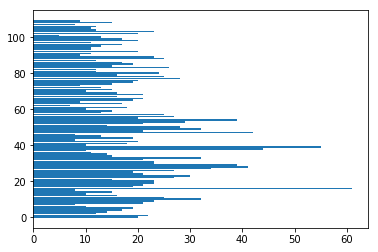

In [169]:
lens = [len(value) for value in topic2docs.values()]
plt.barh([i for i in range(len(topic2docs.keys()))], lens)
plt.savefig("fig_0.png")

Here is the new distribution for document per topic. __Topic7__ is prevalent but it's not as bad as before.

<Container object of 106 artists>

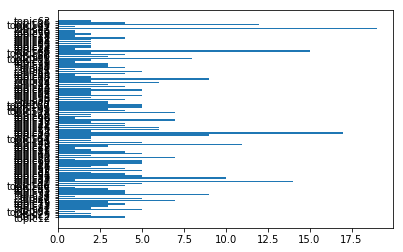

In [170]:
lens = [len(value) for value in test_topic2docs.values()]
keys = len(test_topic2docs.keys())
plt.barh([i for i in range(keys)], lens, tick_label = test_topic2docs.keys())

#### Choosing an answer given texts from the same cluster

In [171]:
# a method to choose answer from the original text AND from texts from the same cluster
# answer as dictionary, original text as list of strings, similar_texts as one list of strings
def choose_answer_v2(original_text, similar_texts, answers):
    original_answer = choose_answer(original_text, answers)
    #if we don't find the answer in the original text
    if original_answer[1] == 0:
        similar_answer = choose_answer(similar_texts, answers)
        return similar_answer
    else:
        return original_answer

In [172]:
def get_topic_by_text_id(text_id, topic2docs):
    for topic in topic2docs.keys():
        for text in topic2docs[topic]:
            if text['text_id'] == text_id:
                return topic

def get_topic_texts(topic, topic2docs):
    texts_list = topic2docs[topic]
    texts = []
    for text in texts_list:
        texts += text['text']
    return texts

In [173]:
def run_v2(data, topic2docs, choose_answer_function):
    results = []
    for instance in data:
        instance_topic = get_topic_by_text_id(instance['text_id'], topic2docs)
        similar_texts = get_topic_texts(instance_topic, topic2docs)
        for question in instance['questions']:
            correct_answers = choose_answer_function(instance['text'], similar_texts, question['answers'])[0]
            question_results = [instance['text_id'], question['question_id'], correct_answers]
            results.append(question_results)
    return results

In [174]:
train_with_bigARTM = run_v2(train_data, train_topic2docs, choose_answer_v2)
print("BigARTM train accuracy: " + str(evaluate(train_with_bigARTM, gold_train)[0]))
dev_with_bigARTM = run_v2(dev_data, dev_topic2docs, choose_answer_v2)
print("BigARTM dev accuracy: " + str(evaluate(dev_with_bigARTM, gold_dev)[0]))
test_with_bigARTM = run_v2(test_data, test_topic2docs, choose_answer_v2)
print("BigARTM test accuracy: " + str(evaluate(test_with_bigARTM, gold_test)[0]))

BigARTM train accuracy: 61.5044702497174
BigARTM dev accuracy: 61.09142452161588
BigARTM test accuracy: 61.38720057204148


In [194]:
print("First 10 incorrent answers: comparison with baseline")
print(evaluate(run(test_data), gold_test)[1][30:40])
print(evaluate(test_with_bigARTM, gold_test)[1][30:40])

First 10 incorrent answers: comparison with baseline
[['7', '5', '1'], ['8', '2', '0'], ['8', '4', '0'], ['9', '0', '0'], ['10', '2', '0'], ['10', '3', '0'], ['10', '5', '0'], ['10', '7', '0'], ['11', '0', '0'], ['11', '1', '0']]
[['8', '4', '0'], ['10', '2', '0'], ['10', '3', '0'], ['10', '5', '0'], ['10', '7', '0'], ['10', '8', '1'], ['11', '0', '0'], ['11', '1', '0'], ['11', '3', '0'], ['11', '4', '1']]


### Part 3. Answering Using Related Script Knowledge
terminology: _topic-script_ is a topic section from DeScript, e.g. baking a cake, flying in an airplane
- mapping text to topic-script
- finding answer in the topic-script

_IDEA_: doc similarity between topic-script and given text with Doc2Vec<br>
_IDEA_: map text to a specific event from the scripts



#### Defining Similarity Between Given Text and Topic-Script

In [177]:
# helper method - from tuples to dictionary
def tuple_to_dict(some_list):
    new_list = {}
    for pair in some_list:
        new_list[pair[0]] = pair[1]
    return new_list

In [178]:
# finding frequencies for topics and scaling them by number of documents
topic_vectors = {}
for topic in topics.keys():
    topic_vectors[topic] = {}
    meaningful_words = list(filter(lambda x: x not in stopwords, topics[topic]))
    words = tuple_to_dict(nltk.FreqDist(meaningful_words).most_common(12))
    
    current_docs = topic_docs[topic]
    for word in words:
        number_of_docs = 0
        for doc in current_docs:
            if word in doc:
                number_of_docs += 1
        topic_vectors[topic][word] = words[word]/number_of_docs

In [179]:
#getting all texts and cleaning
clean_all_texts = []
for text in all_texts:
    ind = text[0].index("|")
    clean_all_texts.append([text[0][ind+6:]])

In [180]:
#getting frequencies for words in all documents
full_texts = []
full_texts = np.append(full_texts, clean_all_texts)
just_text = " ".join(full_texts)
words = nltk.tokenize.word_tokenize(just_text)
fd = nltk.FreqDist(words)


In [181]:
# cleaning and finding frequencies for given text
def get_text_vector(text):
    meaningful_words = list(filter(lambda x: x not in stopwords, text))
    text_vector = tuple_to_dict(nltk.FreqDist(meaningful_words).most_common(12))
    for word, freq in text_vector.items():
        if word in fd:
            text_vector[word] = freq/(fd[word])
    return text_vector

In [182]:
import math
# cosine similarity function to compare two vectors with frequencies
def cosine_similarity(topic_vector, text_vector):
    
    topic_sum = 0
    text_sum = 0
    dot_product = 0
    
    for word in topic_vector:
        topic_sum += (topic_vector[word]**2)
        if word in text_vector.keys():
            text_sum += (text_vector[word]**2)
            dot_product += (topic_vector[word] * text_vector[word])
    topic_norm = math.sqrt(topic_sum)
    text_norm = math.sqrt(text_sum)
    
    if topic_norm * text_norm == 0:
        return 0
    else:
        return dot_product/(topic_norm * text_norm)

In [183]:
# returns most similar topic
def get_topic(text, topic_vectors):
    topic_scores = {}
    for topic in topic_vectors.keys():
        csim = cosine_similarity(topic_vectors[topic], get_text_vector(text))
        topic_scores[topic] = csim
    return max(topic_scores.items(), key=lambda k: k[1])

#### Answering Using Topic-Scripts

In [184]:
def run_v3(data, topic_vectors, topics, choose_answer_function):
    results = []
    for instance in data:
        for question in instance['questions']:
            current_topic = get_topic(instance['text'], topic_vectors)[0]
            correct_answer = choose_answer_function(instance['text'], topics[current_topic], question['answers'])[0]
            results.append([instance['text_id'], question['question_id'], correct_answer])
    return results

In [187]:
des_train = run_v3(train_data, topic_vectors, topics, choose_answer_v2)
print("Descript accuracy train: " + str(evaluate(des_train, gold_train)[0]))
des_dev = run_v3(dev_data, topic_vectors, topics, choose_answer_v2)
print("Descript accuracy dev: " + str(evaluate(des_dev, gold_dev)[0]))
des_test = run_v3(test_data, topic_vectors, topics, choose_answer_v2)
print("Descript accuracy test: " + str(evaluate(des_test, gold_test)[0]))

Descript accuracy train: 60.41516801973076
Descript accuracy dev: 59.67399007795889
Descript accuracy test: 61.67322130854487


### Part 4. Clustering with Doc2Vec

- part 1: embed texts with Doc2Vec
- part 2: cluster embedded representations with KMeans (or other clustering methods)
- part 3: cluster - texts mapping
- part 4: choose answer, using a given text and texts from the same cluster

_Inspired by_: https://towardsdatascience.com/automatic-topic-clustering-using-doc2vec-e1cea88449c

#### Training Doc2Vec and Inferring Vectors for all Texts

In [208]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

In [279]:
data = []
for t in clean_all_texts:
    data.append(nltk.tokenize.word_tokenize(t[0]))

In [280]:
additional_texts_from_descript = []
for topic in topics:
    l = len(topics[topic])
    data.append(topics[topic][:int(l/3)])
    data.append(topics[topic][int(l/3):int(l-(l/3))])
    data.append(topics[topic][int(l-(l/3)):])


In [246]:
class Documents(object):
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words = doc, tags = [i])

In [281]:
documents = Documents(data)

In [282]:
# training the model
count = len(data)
model = Doc2Vec(size=100, dbow_words= 1, dm=0, iter=1,  window=12, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
for epoch in range(30):
    print("epoch "+str(epoch))
    model.train(documents, total_examples=count, epochs=1)
    model.save('commonSense.model')
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
print("done training")

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
done training


In [283]:
# inferring vectors
vectors = []
for d in data:
    vectors.append(model.infer_vector(d))

#### Clustering Using KMeans

In [214]:
from nltk.cluster.kmeans import KMeansClusterer
from collections import Counter

In [284]:
kclusterer = KMeansClusterer(T, distance=nltk.cluster.util.cosine_distance, repeats=20)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)

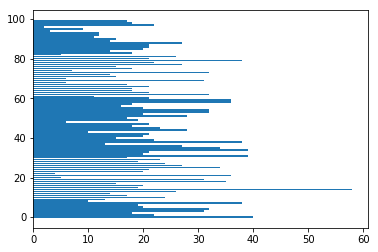

In [261]:
# distribution of clusters per all 2119 texts (from train, dev and test combined)
cnt = Counter(assigned_clusters)
plt.barh([i for i in range(len(cnt.keys()))], [value for value in cnt.values()])
plt.savefig("fig_1.png")

#### Text2Cluster/Cluster2Texts Mapping

In [285]:
# mapping from assigned clusters to actual text_ids from all_texts
mapping_text2cluster = {}
for i in range(len(all_texts)):
    cur_ind = all_texts[i][0].index("|")
    text_id = all_texts[i][0][:cur_ind-1]
    mapping_text2cluster[text_id] = assigned_clusters[i]
mapping_text2cluster['test429']

97

In [286]:
# mapping from cluster number to text_ids
mapping_cluster2texts = {}
for key,value in list(mapping_text2cluster.items()):
    if value not in mapping_cluster2texts:
        mapping_cluster2texts[value] = []
        mapping_cluster2texts[value].append(key)
    else:
        mapping_cluster2texts[value].append(key)

In [264]:
# most frequent clusters
map_cluster_len = {}
for key, value in mapping_cluster2texts.items():
    map_cluster_len[key] = len(value)

import operator
sorted_len = sorted(map_cluster_len.items(), key=operator.itemgetter(1))
sorted_len[-3:]

[(28, 39), (51, 40), (87, 58)]

In [277]:
def get_text_from_mapping_id(mapping_id):
    if 'train' in mapping_id:
        text_id = mapping_id[5:]
        return get_text_by_id(text_id, train_data)['text']
    elif 'dev' in mapping_id:
        text_id = mapping_id[3:]
        return get_text_by_id(text_id, dev_data)['text']
    elif 'test' in mapping_id:
        text_id = mapping_id[4:]
        return get_text_by_id(text_id, test_data)['text']
    
# returns list of lists (with texts divided into words)
def get_all_texts_per_cluster(cluster_number, mapping_cluster2texts):
    current_mapping_ids = mapping_cluster2texts[cluster_number]
    texts_per_cluster = []
    for map_id in current_mapping_ids:
        texts_per_cluster.append(get_text_from_mapping_id(map_id))
    return texts_per_cluster

In [221]:
# MODIFIED TO GET CLEAN TEXTS
def get_text_from_mapping_id_clean(mapping_id):
    if 'train' in mapping_id:
        text_id = mapping_id[5:]
        text_train = get_text_by_id(text_id, train_data)['text']
        return list(filter(lambda x: x not in stopwords, text_train))
    elif 'dev' in mapping_id:
        text_id = mapping_id[3:]
        text_dev = get_text_by_id(text_id, dev_data)['text']
        return list(filter(lambda x: x not in stopwords, text_dev))
    elif 'test' in mapping_id:
        text_id = mapping_id[4:]
        text_test = get_text_by_id(text_id, test_data)['text']
        return list(filter(lambda x: x not in stopwords, text_test))
    
# returns list of lists (with texts divided into words)
def get_all_texts_per_cluster(cluster_number, mapping_cluster2texts):
    current_mapping_ids = mapping_cluster2texts[cluster_number]
    texts_per_cluster = []
    for map_id in current_mapping_ids:
        texts_per_cluster.append(get_text_from_mapping_id_clean(map_id))
    return texts_per_cluster

In [222]:
# to find out top 15 tokens for 3 most frequent clusters
print("cluster 6: " + str(nltk.FreqDist(np.concatenate(get_all_texts_per_cluster(6, mapping_cluster2texts))).most_common(15)))
print("cluster 38: "  + str(nltk.FreqDist(np.concatenate(get_all_texts_per_cluster(38, mapping_cluster2texts))).most_common(15)))
print("cluster 75: " + str(nltk.FreqDist(np.concatenate(get_all_texts_per_cluster(75, mapping_cluster2texts))).most_common(15)))

cluster 6: [('movie', 112), ('dvd', 50), ('watch', 46), ('player', 32), ('play', 23), ('get', 20), ('want', 19), ('decide', 19), ('friend', 18), ('go', 17), ('turn', 17), ('tv', 16), ('back', 14), ('one', 12), ('night', 12)]
cluster 38: [('sauna', 19), ('go', 18), ('room', 13), ('get', 10), ('towel', 9), ('relax', 7), ('minutes', 7), ('change', 6), ('back', 6), ('clothes', 5), ('left', 5), ('use', 5), ('us', 5), ('pay', 4), ('take', 4)]
cluster 75: [('go', 49), ('store', 40), ('get', 30), ('buy', 22), ('shopping', 20), ('car', 20), ('clothes', 18), ('shoes', 18), ('new', 17), ('decide', 16), ('back', 15), ('friend', 15), ('walk', 14), ('like', 14), ('dress', 13)]


#### Choosing an Answer

In [232]:
def run_v5(data, mapping_cluster2texts, mapping_text2cluster, datatype_prefix):
    results = []
    for instance in data:
        cluster_number = mapping_text2cluster[datatype_prefix + instance['text_id']]
        similar_texts = np.concatenate(get_all_texts_per_cluster(cluster_number, mapping_cluster2texts))
        for question in instance['questions']:
            correct_answers = choose_answer_v2(instance['text'], similar_texts, question['answers'])[0]
            question_results = [instance['text_id'], question['question_id'], correct_answers]
            results.append(question_results)
    return results

#### Evaluation

In [224]:
# 20 epochs, no DeScript, window 10
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.06258349604358
Dev accuracy: 60.09922041105599
Test accuracy: 61.70897390060779


In [233]:
# 20 epochs, no DeScript, window 12
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.689446100092496
Dev accuracy: 61.23316796598157
Test accuracy: 61.60171612441903


In [244]:
# 20 epochs, DeScript, window 10
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.59695817490495
Dev accuracy: 61.09142452161588
Test accuracy: 61.56596353235609


In [255]:
# 30 epochs, no DeScript, window 10
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.60723461103689
Dev accuracy: 60.737065910701624
Test accuracy: 61.74472649267072


In [266]:
# 30 epochs, no DeScript, window 12
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.61751104716884
Dev accuracy: 61.02055279943303
Test accuracy: 61.887736860922416


In [278]:
# 30 epochs, DeScript, window 10
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.494193813585454
Dev accuracy: 60.66619418851879
Test accuracy: 61.24419020378977


In [287]:
# 30 epochs, DeScript, window 12
gensim_1_train = run_v5(train_data, mapping_cluster2texts, mapping_text2cluster, 'train')
print("Train accuracy: " + str(evaluate(gensim_1_train, gold_train)[0]))
gensim_1_dev = run_v5(dev_data, mapping_cluster2texts, mapping_text2cluster, 'dev')
print("Dev accuracy: " + str(evaluate(gensim_1_dev, gold_dev)[0]))
gensim_1_test = run_v5(test_data, mapping_cluster2texts, mapping_text2cluster, 'test')
print("Test accuracy: " + str(evaluate(gensim_1_test, gold_test)[0]))

Train accuracy: 61.59695817490495
Dev accuracy: 60.24096385542169
Test accuracy: 61.95924204504827


#### The following part is an attempt to improve an answering method.

### Part 5. Choosing an Answer Based on Similarity
- train doc2vec with sentences from texts, questions and answers
- infer vectors for Q&As
- score answers based on their similarity with the question

#### Training Doc2Vec

In [340]:
from nltk.tokenize import sent_tokenize

In [347]:
def sentence_preprocessing(text):
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sent in sentences:
        tokenized_sentences.append(preprocess_text(sent))
    return tokenized_sentences

In [352]:
def xml2listData_v2(xml_data):
    data = []
    root = ET.XML(xml_data)
    for child in root:
        for subchild in child:
            if subchild.tag == 'text':
                data.append(sentence_preprocessing(subchild.text))
            if subchild.tag == 'questions':
                for question in subchild:
                    data.append(sentence_preprocessing(question.attrib["text"]))
                    for answer in question:
                        data.append(sentence_preprocessing(answer.attrib["text"]))
    return data

In [358]:
new_train = xml2listData_v2(xml_train)
new_dev = xml2listData_v2(xml_dev)
new_test = xml2listData_v2(xml_test)

In [371]:
all_sentences = []
for el in np.concatenate([new_train, new_dev, new_test]):
    for s in el:
        all_sentences.append(s)

In [372]:
class Documents(object):
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words = doc, tags = [i])

In [374]:
doc_sentences = Documents(all_sentences)

In [376]:
# training the model
count = len(all_sentences)
model_sim = Doc2Vec(size=40, dbow_words= 1, dm=0, iter=1,  window=8, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
model_sim.build_vocab(doc_sentences)
for epoch in range(20):
    print("epoch "+str(epoch))
    model_sim.train(doc_sentences, total_examples=count, epochs=1)
    model_sim.save('commonSense_sim.model')
    model_sim.alpha -= 0.002  # decrease the learning rate
    model_sim.min_alpha = model_sim.alpha  # fix the learning rate, no decay
print("done training")

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
done training


#### Inferring Vectors and Answering Questions

In [377]:
from sklearn.metrics import pairwise

In [426]:
def choose_answer_similarity(question, answers, model_sim):
    question_vector = model_sim.infer_vector(question)
    answer_scores = {}
    for answer in answers:
        answer_vector = model_sim.infer_vector(answer['answer_text'])
        answer_scores[answer['answer_id']] = pairwise.cosine_similarity(question_vector.reshape(1, -1), answer_vector.reshape(1, -1))
    best_answer = max(answer_scores.items(), key=lambda k: k[1])[0]
    return best_answer

In [425]:
choose_answer_similarity(new_train[1][0], new_train[2][0], model_sim)[0][0]

0.94402874

In [427]:
def run_v6(data, choose_answer_method, model):
    results = []
    for instance in data:
        for question in instance['questions']:
            correct_answers = choose_answer_method(question['question_text'], question['answers'], model)
            question_results = [instance['text_id'], question['question_id'], correct_answers]
            results.append(question_results)
    return results

In [432]:
evaluate(run_v6(train_data, choose_answer_similarity, model_sim), ideal_results_train)[0]

49.121364710718325

In [433]:
evaluate(run_v6(dev_data, choose_answer_similarity, model_sim), ideal_results_dev)[0]

49.82282069454288